# Modelling

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from lightgbm import LGBMRegressor

In [2]:
DATA_DIR = '../data'

In [3]:
data = pd.read_csv("{}/processed/dataset.csv".format(DATA_DIR))

In [4]:
df = data[~pd.isnull(data['points'])]

In [5]:
train = df[df['date'] < "2020-10-01"]
val = df[df['date'] >= "2020-10-01"]
test = data[pd.isnull(data['points'])]

In [6]:
train.shape

(4352, 79)

In [7]:
val.shape

(2695, 79)

In [8]:
test.shape

(1057, 79)

In [9]:
train.head()

,player,date,league_name,team_name,opponent_name,fantasy_points,min,position,year,month,...,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,Artem Dzyuba,2019-06-08,European Championship Qualifiers,Russia,San Marino,73.66,90.0,F,2019,6,...,73.0,77.0,70.0,15.0,19.0,15.0,12.0,11.0,11.0,8.0
1,Cristiano Ronaldo,2019-09-10,European Championship Qualifiers,Portugal,Lithuania,56.70,79.0,F,2019,9,...,82.0,85.0,95.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,Memphis Depay,2019-03-21,European Championship Qualifiers,Netherlands,Belarus,54.00,90.0,F,2019,3,...,78.0,75.0,76.0,31.0,20.0,8.0,14.0,6.0,12.0,10.0
3,Denis Cheryshev,2019-10-13,European Championship Qualifiers,Russia,Cyprus,53.32,90.0,M,2019,10,...,74.0,64.0,66.0,55.0,52.0,16.0,7.0,14.0,7.0,8.0
4,Cristiano Ronaldo,2019-11-14,European Championship Qualifiers,Portugal,Lithuania,51.80,83.0,F,2019,11,...,82.0,85.0,95.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0


In [10]:
train.columns

Index(['player', 'date', 'league_name', 'team_name', 'opponent_name',
       'fantasy_points', 'min', 'position', 'year', 'month', 'day', 'points',
       'prev_mean_points', 'prev_mean_goals', 'prev_mean_assists',
       'prev_median_min', 'prev_starter_rate', 'count_play',
       'goal_consistency', 'assist_consistency', 'clean_sheet_consistency',
       'prev_team_highest_rank', 'team_rank', 'team_total_points',
       'prev_opponent_highest_rank', 'opponent_rank', 'opponent_total_points',
       'mean_squad_age', 'market_value', 'mean_market_value', 'age',
       'height_cm', 'weight_kg', 'league_rank', 'overall', 'potential',
       'wage_eur', 'international_reputation', 'pace', 'shooting', 'passing',
       'dribbling', 'defending', 'nation_position', 'nation_jersey_number',
       'physic', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_ac

In [11]:
columns = ['player', 'league_name', 'date', 'year', 'month', 'day', 'nation_jersey_number',
           'team_name', 'opponent_name', 'points', 'fantasy_points', 'nation_position']

In [12]:
X_train = pd.get_dummies(train.drop(columns, axis=1))
y_train = train["points"]

In [13]:
X_val = pd.get_dummies(val.drop(columns, axis=1))
y_val = val["points"]

In [14]:
X_test = pd.get_dummies(test.drop(columns, axis=1))

In [15]:
X_train.columns

Index(['min', 'prev_mean_points', 'prev_mean_goals', 'prev_mean_assists',
       'prev_median_min', 'prev_starter_rate', 'count_play',
       'goal_consistency', 'assist_consistency', 'clean_sheet_consistency',
       'prev_team_highest_rank', 'team_rank', 'team_total_points',
       'prev_opponent_highest_rank', 'opponent_rank', 'opponent_total_points',
       'mean_squad_age', 'market_value', 'mean_market_value', 'age',
       'height_cm', 'weight_kg', 'league_rank', 'overall', 'potential',
       'wage_eur', 'international_reputation', 'pace', 'shooting', 'passing',
       'dribbling', 'defending', 'physic', 'attacking_crossing',
       'attacking_finishing', 'attacking_heading_accuracy',
       'attacking_short_passing', 'attacking_volleys', 'skill_dribbling',
       'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
       'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed',
       'movement_agility', 'movement_reactions', 'movement_balance',
       'powe

In [16]:
model = LGBMRegressor(random_state=1)

In [17]:
model.fit(X_train, y_train)

LGBMRegressor(random_state=1)

In [18]:
set(X_train.columns) - set(X_val.columns)

set()

In [19]:
X_val = X_val[X_train.columns]

In [20]:
X_test = X_test[X_train.columns]

In [21]:
val["predicted"] = model.predict(X_val)

<ipython-input-21-c0d048da6697>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val["predicted"] = model.predict(X_val)


In [22]:
test["predicted"] = model.predict(X_test)

<ipython-input-22-604eb472f157>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predicted"] = model.predict(X_test)


In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [24]:
mae = mean_absolute_error(val["predicted"], val['points'].values)

In [25]:
mae

1.7052760661786315

In [26]:
val["error"] = val["points"] - val["predicted"]

<ipython-input-26-6b470be075c8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val["error"] = val["points"] - val["predicted"]


In [27]:
val["abs_error"] = val["error"].apply(lambda x: abs(x))

<ipython-input-27-ff4fa84ad4a6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val["abs_error"] = val["error"].apply(lambda x: abs(x))


In [28]:
val.sort_values(by=["abs_error"], ascending=False).head(10)

,player,date,league_name,team_name,opponent_name,fantasy_points,min,position,year,month,...,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,predicted,error,abs_error
15,Ferran Torres,2020-11-17,UEFA Nations League,Spain,Germany,45.02,73.0,M,2020,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.490018,14.509982,14.509982
6,Mikkel Damsgaard,2021-03-28,European World Cup Qualifiers,Denmark,Moldova,50.42,90.0,M,2021,3,...,46.0,40.0,6.0,10.0,14.0,11.0,7.0,4.831129,14.168871,14.168871
14,Tomas Soucek,2021-03-24,European World Cup Qualifiers,Czech Republic,Estonia,45.18,90.0,M,2021,3,...,80.0,79.0,11.0,13.0,5.0,6.0,8.0,2.909499,14.090501,14.090501
16,Phil Foden,2020-11-18,UEFA Nations League,England,Iceland,44.34,90.0,M,2020,11,...,58.0,47.0,8.0,15.0,6.0,10.0,13.0,3.595133,12.404867,12.404867
46,Diogo Jota,2020-10-14,UEFA Nations League,Portugal,Sweden,37.64,88.0,M,2020,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.375873,11.624127,11.624127
68,Kieran Tierney,2021-03-31,European World Cup Qualifiers,Scotland,Faroe Islands,34.54,79.0,D,2021,3,...,74.0,74.0,13.0,16.0,8.0,12.0,13.0,3.507427,11.492573,11.492573
23,Hans Vanaken,2021-03-30,European World Cup Qualifiers,Belgium,Belarus,42.48,90.0,M,2021,3,...,56.0,51.0,13.0,6.0,9.0,15.0,11.0,4.761762,11.238238,11.238238
138,Ozan Tufan,2021-03-27,European World Cup Qualifiers,Turkey,Norway,29.82,86.0,M,2021,3,...,74.0,71.0,6.0,14.0,8.0,7.0,15.0,2.039348,10.960652,10.960652
38,Robert Lewandowski,2020-10-14,UEFA Nations League,Poland,Bosnia and Herzegovina,38.86,58.0,F,2020,10,...,42.0,19.0,15.0,6.0,12.0,8.0,10.0,1.562429,10.437571,10.437571
6930,Yann Sommer,2020-11-14 00:00:00,UEFA Nations League,Switzerland,Spain,16.66,90.0,GK,2020,11,...,19.0,12.0,79.0,85.0,81.0,80.0,87.0,3.672261,10.327739,10.327739


In [29]:
pd.pivot_table(val, index=["position"], values=["error"], aggfunc="mean")

,error
position,
D,0.019204
F,0.152911
GK,-0.041338
M,0.178287


<AxesSubplot:xlabel='predicted', ylabel='points'>

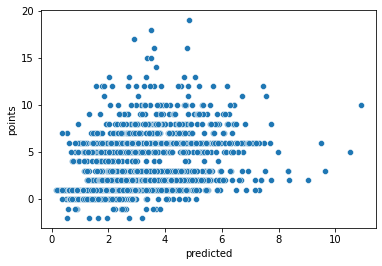

In [30]:
sns.scatterplot(data=val, x="predicted", y="points")

## The Dream Team

In [31]:
fantasy_euro = pd.read_csv("{}/interim/fantasy_euro.csv".format(DATA_DIR))

In [32]:
fantasy_euro = fantasy_euro[["player", "date", "league_name", "team_name", 
                             "opponent_name", "value", "skill", "sel_per"]]

In [33]:
players = pd.merge(test[["player", "position", "team_name", "opponent_name", "predicted", "count_play", "prev_starter_rate", "goal_consistency"]], 
                   fantasy_euro[["player", "value", "skill", "sel_per"]],
                   how='left', on="player")

In [34]:
players["value_for_money"] = players["predicted"] / players["value"]
players["round_predicted"] = players["predicted"].apply(lambda x: round(x))

In [35]:
players = players[~pd.isnull(players['position'])]
players = players[players['prev_starter_rate'] > 0.75]
players = players[players['count_play'] > 3]

In [36]:
players = players.sort_values(by=["round_predicted", "value_for_money"], ascending=False)

In [37]:
gk = players[players["position"] == "GK"]
gk = gk.sort_values(by=["prev_starter_rate","count_play","round_predicted", "value_for_money"], ascending=False)
gk = gk.drop_duplicates(subset=["team_name"], keep="first")
gk = gk.sort_values(by=["round_predicted", "value_for_money"], ascending=False)
gk.head(20)

,player,position,team_name,opponent_name,predicted,count_play,prev_starter_rate,goal_consistency,value,skill,sel_per,value_for_money,round_predicted
845,Péter Gulácsi,GK,Hungary,Portugal,2.235561,19.0,1.0,0.0,4.5,1,3.0,0.496791,2
669,Robin Olsen,GK,Sweden,Spain,2.053119,19.0,1.0,0.0,5.0,1,1.0,0.410624,2
663,Unai Simón,GK,Spain,Sweden,2.039614,6.0,1.0,0.0,5.0,1,1.0,0.407923,2
737,Dominik Livakovic,GK,Croatia,England,1.992612,18.0,1.0,0.0,5.0,1,1.0,0.398522,2
569,Andriy Pyatov,GK,Ukraine,Netherlands,1.903450,15.0,1.0,0.0,5.0,1,0.0,0.380690,2
620,Tomás Vaclik,GK,Czech Republic,Scotland,1.801559,16.0,1.0,0.0,5.0,1,0.0,0.360312,2
759,Ugurcan Çakir,GK,Turkey,Italy,1.539067,6.0,1.0,0.0,4.5,1,1.0,0.342015,2
838,Stole Dimitrievski,GK,North Macedonia,Austria,1.512102,22.0,1.0,0.0,4.5,1,0.0,0.336023,2
1067,Lukás Hrádecky,GK,Finland,Denmark,1.331671,20.0,1.0,0.0,4.0,1,34.0,0.332918,1
596,Yann Sommer,GK,Switzerland,Wales,1.352032,21.0,1.0,0.0,5.0,1,3.0,0.270406,1


In [38]:
players[players["position"] == "D"].head(20)

,player,position,team_name,opponent_name,predicted,count_play,prev_starter_rate,goal_consistency,value,skill,sel_per,value_for_money,round_predicted
654,Robin Gosens,D,Germany,France,2.499955,5.0,0.800000,0.000000,5.0,2,1.0,0.499991,2
835,Léo Dubois,D,France,Germany,2.014101,7.0,0.857143,0.000000,4.5,2,0.0,0.447578,2
841,Marcus Danielson,D,Sweden,Spain,1.911082,6.0,1.000000,0.333333,4.5,2,0.0,0.424685,2
860,Pierre Bengtsson,D,Sweden,Spain,1.879408,12.0,0.916667,0.000000,4.5,2,0.0,0.417646,2
566,Vladimir Coufal,D,Czech Republic,Scotland,1.976384,12.0,1.000000,0.083333,5.0,2,9.0,0.395277,2
552,Dejan Lovren,D,Croatia,England,1.953654,17.0,1.000000,0.117647,5.0,2,1.0,0.390731,2
779,Pau Torres,D,Spain,Sweden,1.726141,7.0,0.857143,0.142857,4.5,2,17.0,0.383587,2
553,Mikael Lustig,D,Sweden,Spain,1.905573,12.0,1.000000,0.000000,5.0,2,0.0,0.381115,2
791,Ondrej Kudela,D,Czech Republic,Scotland,1.636837,7.0,0.857143,0.000000,4.5,2,0.0,0.363742,2
441,Timothy Castagne,D,Belgium,Russia,1.993600,13.0,0.846154,0.153846,5.5,2,6.0,0.362473,2


In [39]:
players[(players["position"] == "M")].head(20)

,player,position,team_name,opponent_name,predicted,count_play,prev_starter_rate,goal_consistency,value,skill,sel_per,value_for_money,round_predicted
6,Kevin De Bruyne,M,Belgium,Russia,3.457128,12.0,1.000000,0.416667,10.5,3,33.0,0.329250,3
18,Raheem Sterling,M,England,Croatia,2.961531,17.0,1.000000,0.470588,9.5,3,1.0,0.311740,3
335,Jorginho,M,Italy,Turkey,2.178482,9.0,1.000000,0.333333,6.0,3,1.0,0.363080,2
716,Eric Dier,M,England,Croatia,1.744569,12.0,0.833333,0.000000,5.0,2,0.0,0.348914,2
481,Sergio Busquets,M,Spain,Sweden,1.807538,15.0,1.000000,0.000000,5.5,3,1.0,0.328643,2
393,Remo Freuler,M,Switzerland,Wales,1.758636,17.0,0.823529,0.176471,5.5,3,0.0,0.319752,2
224,Dominik Szoboszlai,M,Hungary,Portugal,1.974002,12.0,0.916667,0.250000,6.5,3,1.0,0.303693,2
249,Marlos,M,Ukraine,Netherlands,1.584502,5.0,1.000000,0.000000,6.0,3,0.0,0.264084,2
304,Enis Bardhi,M,North Macedonia,Austria,1.559285,21.0,0.952381,0.238095,6.0,3,0.0,0.259881,2
226,Lukáš Provod,M,Czech Republic,Scotland,1.648261,7.0,0.857143,0.142857,6.5,3,0.0,0.253579,2


In [40]:
players[players["position"] == "F"].head(30)

,player,position,team_name,opponent_name,predicted,count_play,prev_starter_rate,goal_consistency,value,skill,sel_per,value_for_money,round_predicted
52,Olivier Giroud,F,France,Germany,2.923660,26.0,0.769231,0.423077,8.0,4,1.0,0.365458,3
25,Dries Mertens,F,Belgium,Russia,2.537694,21.0,0.904762,0.285714,9.0,4,3.0,0.281966,3
5,Antoine Griezmann,F,France,Germany,3.046297,28.0,0.928571,0.357143,11.0,4,3.0,0.276936,3
1,Kylian Mbappé,F,France,Germany,2.742764,20.0,0.800000,0.400000,12.0,4,34.0,0.228564,3
308,Ádám Szalai,F,Hungary,Portugal,2.255592,24.0,0.958333,0.291667,6.0,4,0.0,0.375932,2
190,Andrej Kramaric,F,Croatia,England,1.792863,13.0,0.769231,0.307692,6.5,4,1.0,0.275825,2
31,Andriy Yarmolenko,F,Ukraine,Netherlands,2.107077,13.0,1.000000,0.230769,8.5,3,0.0,0.247891,2
195,Lyndon Dykes,F,Scotland,Czech Republic,1.508531,10.0,0.900000,0.200000,6.5,4,0.0,0.232082,2
11,Ciro Immobile,F,Italy,Turkey,2.181773,13.0,0.769231,0.307692,10.0,4,8.0,0.218177,2
2,Harry Kane,F,England,Croatia,2.429215,23.0,0.869565,0.478261,11.5,4,43.0,0.211236,2
